In [66]:
# Importação das blibiotecas
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
!pip install xgboost
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

In [2]:
# Carregamento do arquivo .csv
df = pd.read_csv('hypothyroid.csv')

In [3]:
# visualização do dataset
df.describe(include='all')

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,TT4 measured,TT4,T4U measured,T4U,FTI measured,FTI,TBG measured,TBG,referral source,binaryClass
count,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772,...,3772,3772,3772,3772,3772,3772,3772,3772,3772,3772
unique,94,3,2,2,2,2,2,2,2,2,...,2,242,2,147,2,235,1,1,5,2
top,59,F,f,f,f,f,f,f,f,f,...,t,?,t,?,t,?,f,?,other,P
freq,95,2480,3308,3722,3729,3625,3719,3719,3713,3538,...,3541,231,3385,387,3387,385,3772,3772,2201,3481


**Informaçõesdo paciente**

* age: idade do paciente
* sex: sexo do paciente
  
**Histórico de medicamentos e condições**

* on thyroxine: tomando tiroxina (medicação usada para hipotireoidismo).
* query on thyroxine:  suspeita de que ela deveria estar tomando tiroxina.
* on antithyroid medication: está tomando remédio para hipertireoidismo.
* sick: está doente de outra coisa (não necessariamente tireoide).
* pregnant: está grávida.
* thyroid surgery:  já fez cirurgia de tireoide.
* I131 treatment: recebeu tratamento com iodo radioativo (I-131).
* query hypothyroid: suspeita clínica de hipotireoidismo.
* query hyperthyroid: suspeita clínica de hipertireoidismo.
* lithium: usa lítio (que afeta a tireoide).
* goitre: presença de bócio.
* tumor: presença de tumor relacionado.
* hypopituitary: possível problema na hipófise (que regula hormônios da tireoide).
* psych:  pessoa tem algum distúrbio psicológico relatado.

**Exames e suas medições**

* Com "Measure": Se o exame foi medido ou não
* Sem "Measure": Valor do exame e foi aplicado
* Os TSH, T3, TT4, T4U, FTI,TBG são referente as criação, quantidade e transporte de hormônias

**Locais aonde veis os examex**

* referral source: nos traz deonde vieram os exames

**Variavel Target**

* binaryClass: nossa variavel target que informa p para positivo com problema para tireoide e N para negativo


# Pre processamento

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3772 entries, 0 to 3771
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   age                        3772 non-null   object
 1   sex                        3772 non-null   object
 2   on thyroxine               3772 non-null   object
 3   query on thyroxine         3772 non-null   object
 4   on antithyroid medication  3772 non-null   object
 5   sick                       3772 non-null   object
 6   pregnant                   3772 non-null   object
 7   thyroid surgery            3772 non-null   object
 8   I131 treatment             3772 non-null   object
 9   query hypothyroid          3772 non-null   object
 10  query hyperthyroid         3772 non-null   object
 11  lithium                    3772 non-null   object
 12  goitre                     3772 non-null   object
 13  tumor                      3772 non-null   object
 14  hypopitu

In [7]:
# Alteração do "?" po NaN
# Na pre avaliação os exames que não foram feito apresenta ? para informar que não teve valor

df = df.replace('?', np.nan)

C:\Users\ediloy\AppData\Local\Temp\ipykernel_22288\5899481.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace('?', np.nan)


In [8]:
# Alteração de T para 1 e F para 0 
tf_cols = [
    col for col in df.columns
    if df[col].dropna().isin(['t', 'f']).all()
]

for col in tf_cols:
    df[col] = df[col].map({'t': 1, 'f': 0})

In [9]:
# Alteração da coluna sex M para 1 e F para 0 
df["sex"] = df["sex"].map({'M': 1, 'F': 0})

In [10]:
# Alteração da coluna binaryClass nossa target  de P para 1 e N para 0
df["binaryClass"] = df["binaryClass"].map({'P': 1, 'N': 0})

In [11]:
# Alteração da colunas categoricas para numericas
num_cols = ['age', 'TSH', 'T3', 'TT4', 'T4U', 'FTI', 'TBG','sex','binaryClass']

for col in num_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

In [12]:
df["age"].describe()

count    3771.000000
mean       51.735879
std        20.084958
min         1.000000
25%        36.000000
50%        54.000000
75%        67.000000
max       455.000000
Name: age, dtype: float64

In [13]:
# Mantém apenas as linhas com idade entre 0 e 100 anos
# Apos o tratamento gerou um outleir fora da curso 
df = df[(df["age"] >= 0) & (df["age"] <= 100)]

In [14]:
df.isna().sum().sort_values(ascending=False)

TBG                          3770
T3                            769
T4U                           387
FTI                           385
TSH                           369
TT4                           231
sex                           150
age                             0
referral source                 0
TBG measured                    0
FTI measured                    0
T4U measured                    0
TT4 measured                    0
T3 measured                     0
TSH measured                    0
psych                           0
hypopituitary                   0
tumor                           0
goitre                          0
lithium                         0
query hyperthyroid              0
query hypothyroid               0
I131 treatment                  0
thyroid surgery                 0
pregnant                        0
sick                            0
on antithyroid medication       0
query on thyroxine              0
on thyroxine                    0
binaryClass   

In [15]:
# Colunas que sex ou age que estão vazias não vai ser possivel tratar pois conta que pode apresentar vies, assim vamos retirar
df = df.dropna(subset=["age"])
df = df.dropna(subset=["sex"])

As colunas TSH, T3, TT4, T4U, TBG e FTI são informações reais, se as colunas MEASURED estão com valor 0 o exame não foi precisa realizar assim as colunas não tem informação, sendo assim são informações concretas.

In [17]:
# Criar o encoder
encoder = OneHotEncoder(sparse_output=False, handle_unknown="ignore")

# Ajustar e transformar a coluna
encoded = encoder.fit_transform(df[["referral source"]])

# Recuperar nomes das novas colunas
encoded_cols = encoder.get_feature_names_out(["referral source"])

# Criar DataFrame com os nomes corretos
df_encoded = pd.DataFrame(encoded, columns=encoded_cols, index=df.index)

# Concatenar ao dataframe original
df = pd.concat([df.drop(columns=["referral source"]), df_encoded], axis=1)

In [18]:
df.head()

,age,sex,on thyroxine,query on thyroxine,on antithyroid medication,sick,pregnant,thyroid surgery,I131 treatment,query hypothyroid,...,FTI measured,FTI,TBG measured,TBG,binaryClass,referral source_STMW,referral source_SVHC,referral source_SVHD,referral source_SVI,referral source_other
0,41.0,0.0,0,0,0,0,0,0,0,0,...,1,109.0,0,NaN,1,0.0,1.0,0.0,0.0,0.0
1,23.0,0.0,0,0,0,0,0,0,0,0,...,0,NaN,0,NaN,1,0.0,0.0,0.0,0.0,1.0
2,46.0,1.0,0,0,0,0,0,0,0,0,...,1,120.0,0,NaN,1,0.0,0.0,0.0,0.0,1.0
3,70.0,0.0,1,0,0,0,0,0,0,0,...,0,NaN,0,NaN,1,0.0,0.0,0.0,0.0,1.0
4,70.0,0.0,0,0,0,0,0,0,0,0,...,1,70.0,0,NaN,1,0.0,0.0,0.0,1.0,0.0


In [19]:
# tranto os valores NaN
# Assim os modelos vão entender de quem não fez o exame não esta ligado a ter hipotireoidismo
exam_cols = ["TSH", "T3", "TT4", "T4U", "FTI"]

df[exam_cols] = df[exam_cols].fillna(-1)

In [34]:
# TBG measured e TBG estão completamente vazias, assim sera retirado
df = df.drop(columns=["TBG measured", "TBG"])

# Verificação de relação das variaveis com a variavel target

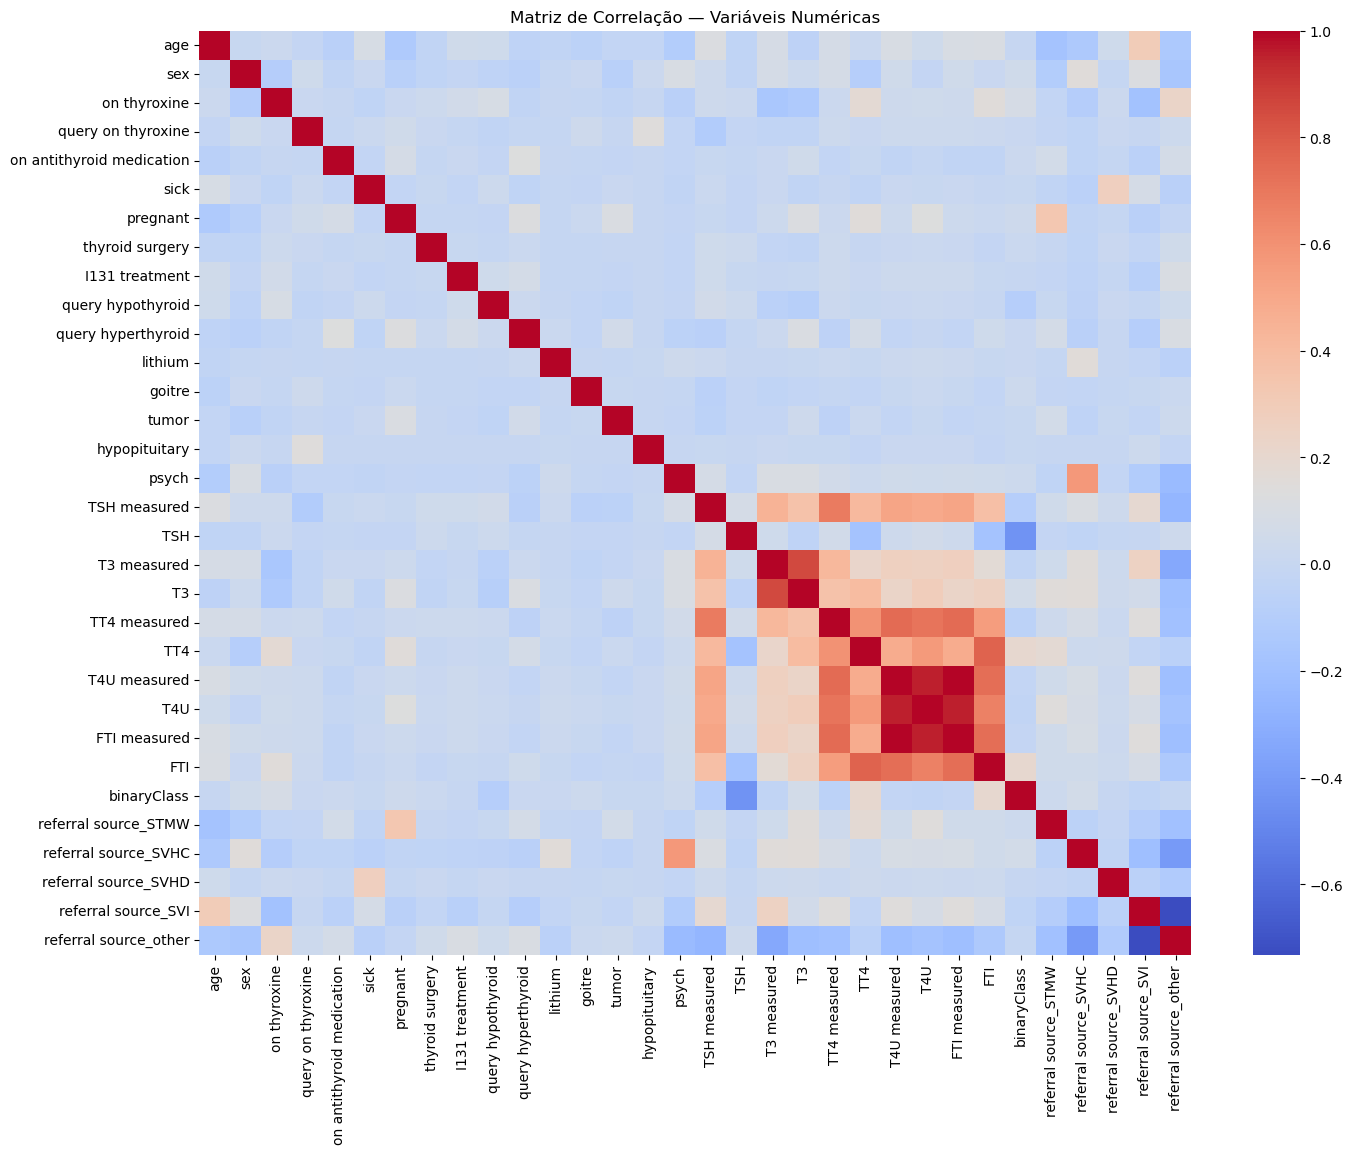

In [36]:
df_num = df.select_dtypes(include=["int64", "float64"])

# Matriz de correlação
corr_matrix = df_num.corr()

plt.figure(figsize=(16,12))
sns.heatmap(corr_matrix, cmap="coolwarm", annot=False)
plt.title("Matriz de Correlação — Variáveis Numéricas")
plt.show()

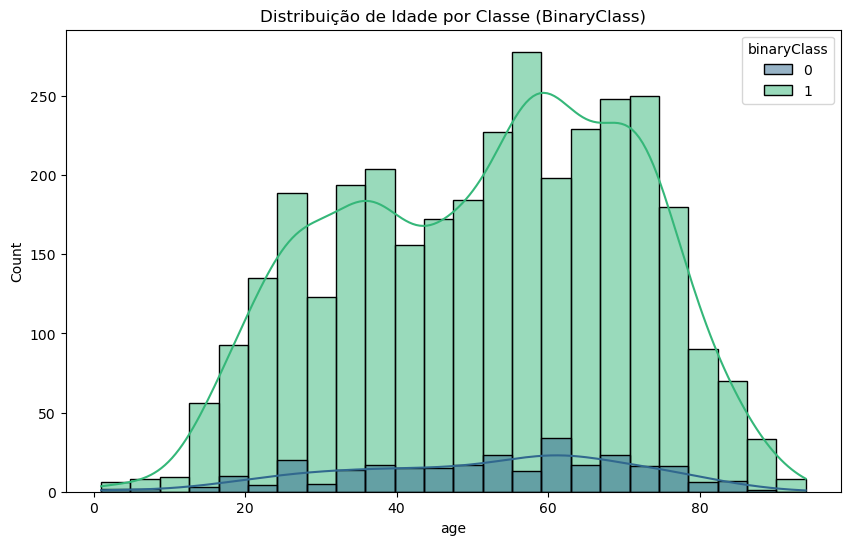

In [38]:
# Targe x Age
plt.figure(figsize=(10,6))
sns.histplot(data=df, x="age", hue="binaryClass", kde=True, palette="viridis")
plt.title("Distribuição de Idade por Classe (BinaryClass)")
plt.show()

Podemos verificar que a base contem mais registros do 0 que não possui hipotireoidismo que 1 que possui hipotireoidismo
e também podemos verificar que não possuiu um certo grupo que é atingido, mas somente um crescimento dentre 20 a 70 anos.

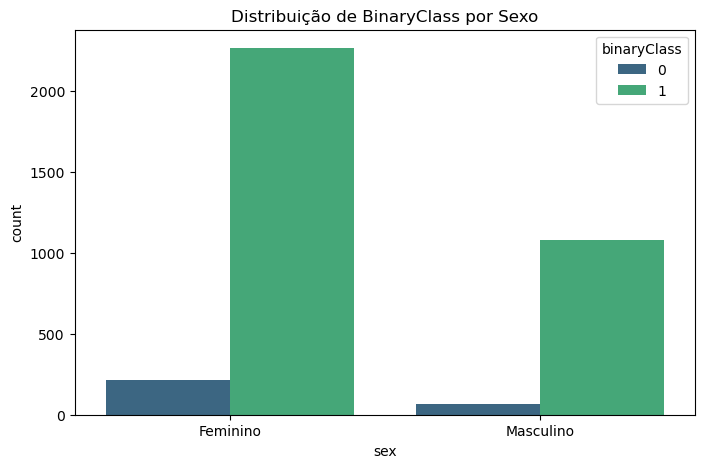

In [41]:
# Target x Sex
plt.figure(figsize=(8,5))
sns.countplot(data=df, x="sex", hue="binaryClass", palette="viridis")
plt.xticks([0, 1], ['Feminino', 'Masculino'])
plt.title("Distribuição de BinaryClass por Sexo")
plt.show()


Comparando entre genero podemos verificar que o hipotireoidismo atinge mais as mulheres que os homens

# criação dos modelos.

In [43]:
# Separa o dataset em treino e teste
X = df.drop(columns=["binaryClass"])
y = df["binaryClass"]

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [47]:
# utilizando smote para balancear o modelo
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# treinamento dos modelos

O modelo que vai ser utilizado final vai ser o XGBClassifier, por ser um modelo mais robusto e mais preparado para prever, mas também vou rodar outros modelo para fazer uma comparação dos resultados

In [70]:
# Logistic Regression

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_smote)
X_test_scaled = scaler.transform(X_test)

log_reg = LogisticRegression(max_iter=500)
log_reg.fit(X_train_scaled, y_train_smote)
y_pred_lr = log_reg.predict(X_test_scaled)
print("Logistic Regression:")
print(classification_report(y_test, y_pred_lr))

Logistic Regression:
              precision    recall  f1-score   support

           0       0.75      0.91      0.82        56
           1       0.99      0.97      0.98       668

    accuracy                           0.97       724
   macro avg       0.87      0.94      0.90       724
weighted avg       0.97      0.97      0.97       724



In [54]:
# Random Forest
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train_smote, y_train_smote)
y_pred_rf = rf.predict(X_test)
print("Random Forest:")
print(classification_report(y_test, y_pred_rf))


Random Forest:
              precision    recall  f1-score   support

           0       0.95      1.00      0.97        56
           1       1.00      1.00      1.00       668

    accuracy                           1.00       724
   macro avg       0.97      1.00      0.99       724
weighted avg       1.00      1.00      1.00       724



In [60]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train_smote, y_train_smote)
y_pred_dt = dt.predict(X_test)
print("Decision Tree:")
print(classification_report(y_test, y_pred_dt))

Decision Tree:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96        56
           1       1.00      1.00      1.00       668

    accuracy                           0.99       724
   macro avg       0.97      0.99      0.98       724
weighted avg       0.99      0.99      0.99       724



In [74]:
# XGBoost
xgb = XGBClassifier(
    random_state=42,
    eval_metric="logloss"
)
xgb.fit(X_train_smote, y_train_smote)
y_pred_xgb = xgb.predict(X_test)
print("XGBoost:")
print(classification_report(y_test, y_pred_xgb))

XGBoost:
              precision    recall  f1-score   support

           0       0.92      0.98      0.95        56
           1       1.00      0.99      1.00       668

    accuracy                           0.99       724
   macro avg       0.96      0.99      0.97       724
weighted avg       0.99      0.99      0.99       724



O modelo previu perfeitamente o modulo, isso pode ser algo certo ou errado.

In [80]:
# Verificação das features
importances = pd.Series(rf.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=False).head(10)

TSH                      0.537239
TT4                      0.085641
FTI                      0.082304
T3                       0.053531
sex                      0.052350
referral source_other    0.040173
referral source_SVI      0.028812
on thyroxine             0.023672
TSH measured             0.020754
T4U                      0.020141
dtype: float64

In [82]:
df.corr()["binaryClass"].sort_values(ascending=False)

binaryClass                  1.000000
FTI                          0.201247
TT4                          0.199368
on thyroxine                 0.080551
T3                           0.063496
referral source_SVHC         0.061100
sex                          0.051918
pregnant                     0.034611
goitre                       0.028193
referral source_STMW         0.028126
psych                        0.027880
on antithyroid medication    0.022201
thyroid surgery              0.017573
query hyperthyroid           0.011523
query on thyroxine           0.007070
lithium                      0.005767
hypopituitary                0.004813
tumor                        0.001760
sick                         0.000323
referral source_SVHD        -0.001420
age                         -0.002236
I131 treatment              -0.007022
referral source_other       -0.010057
FTI measured                -0.021403
T4U measured                -0.021881
T4U                         -0.029322
T3 measured 

Com isso verificação que não teve nenhuma alta relação, assim o tratamento foi aplicado corretamente e os modelos fizeram uma previssão corretamente.

In [ ]:
Como resultado final o XGBClassifier se 